In [10]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy
from cgi_phasec_poppy import ensure_np_array
from cgi_phasec_poppy.imshows import *

iwa = 6
owa = 20

data_dir = cgi_phasec_poppy.data_dir

# dm1_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
# dm2_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

# Test monochromatic PSFs.

0.1 0.005018897251342104 arcsec / pix
Propagating wavelength 575.000 nm.
PSF calculated in 0.629s


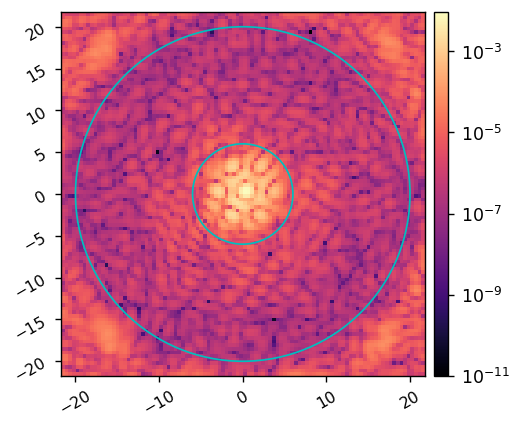

In [32]:
reload(cgi_phasec_poppy.cgi)
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide_band1', npsf=100,
                                use_pupil_defocus=True, use_opds=True)


mode.use_fpm = False
wf = mode.calc_psf(quiet=False)
unocc_psf = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
imshow1(unocc_psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches, vmin=1e-11)

In [ ]:
spc.use_opds

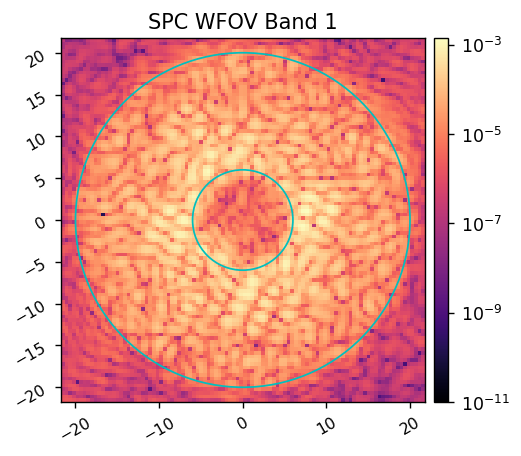

In [33]:
mode.Imax_ref = unocc_psf.max()
mode.use_fpm = True
psf = mode.snap()

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
imshow1(psf, 'SPC WFOV Band 1', lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches, vmin=1e-11)

In [5]:
%%timeit
psf = mode.snap()

625 ms ± 6.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
import misc_funs as misc
misc.save_fits('poppy_spc_wfov_band1_image.fits',psf)

Saved data to:  poppy_spc_wfov_band1_image.fits


In [34]:
import scipy
proper_im = fits.getdata('proper_spc_wfov_band1_aberrated_image.fits')

poppy_im = scipy.ndimage.shift(np.rot90(np.rot90(ensure_np_array(psf))), (1,1))

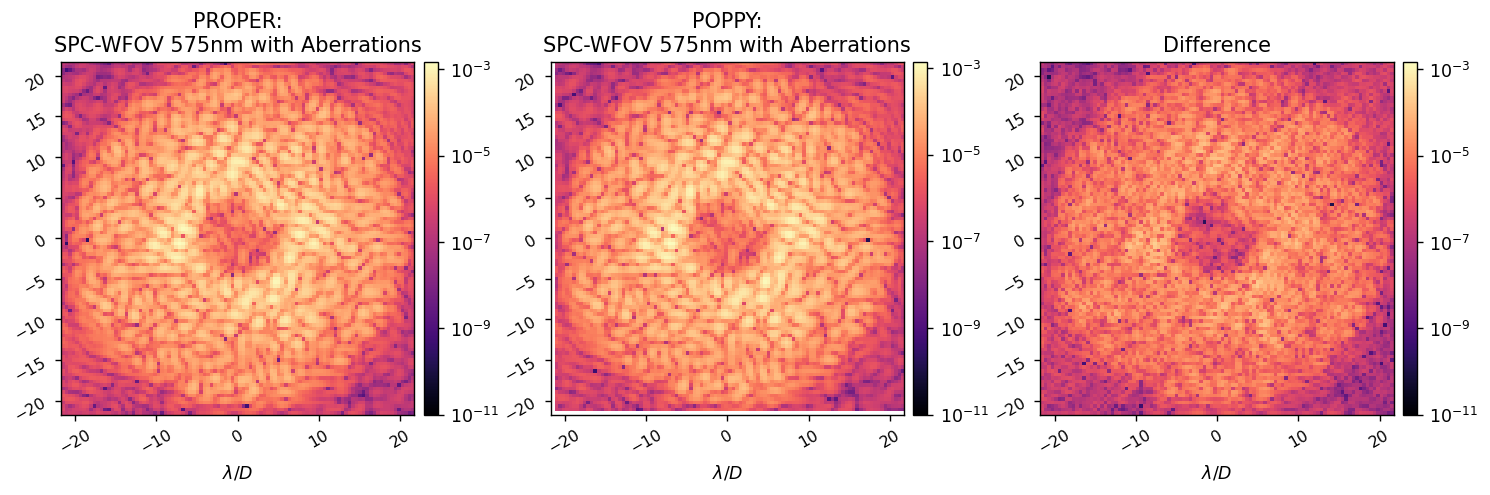

In [35]:
imname = 'SPC-WFOV 575nm with Aberrations'
imshow3(proper_im, poppy_im, abs(proper_im-poppy_im),
        'PROPER:\n'+imname, 'POPPY:\n'+imname, 'Difference', 
        lognorm1=True, lognorm2=True, 
        vmin1=1e-11, vmin2=1e-11, 
        lognorm3=True,
        vmax3=np.max(np.concatenate([proper_im, poppy_im])),
        vmin3=1e-11,
        pxscl=mode.psf_pixelscale_lamD,
        xlabel='$\lambda/D$'
#         vmax3=10,
       )